In [28]:
import os
import numpy as np
import mido
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Masking

import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import librosa


### Data Pre-Processing

In [29]:
def preprocess_midi(file_path):
    midi = mido.MidiFile(file_path)
    notes = []
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                notes.append(msg.note)
    return notes

def load_data(composer_dir, current_label, data, labels, success_files, exception_files):
    print(f'Loading {composer_dir} for {current_label}...')
    for file_or_dir in os.listdir(composer_dir):

        # recursively load data if it is a directory
        if os.path.isdir(os.path.join(composer_dir, file_or_dir)):
            load_data(os.path.join(composer_dir, file_or_dir), current_label, data, labels, success_files, exception_files)
            continue
        
        # print(f'    Loading {file_or_dir}...')
        file = file_or_dir
        file_path = os.path.join(composer_dir, file)
        if file_path.endswith('.mid'):
            try:
                notes = preprocess_midi(file_path)
                data.append(notes)
                labels.append(current_label)
                success_files.append(file_path)
            except Exception as e:
                print(f"Error processing {file_path}: {e}") 
                exception_files.append(file_path)


composer_dirs = [
    'music_data/midiclassics/Bach', 
    'music_data/midiclassics/Beethoven', 
    'music_data/midiclassics/Chopin', 
    'music_data/midiclassics/Mozart']

data = []
labels = []
success_files = []
exception_files = []

# Load data
for current_label, composer_dir in enumerate(composer_dirs):
    load_data(composer_dir, current_label, data, labels, success_files, exception_files)

# Put into DataFrame
df = pd.DataFrame({'data': data, 'label': labels})

print(f"Success files: {len(success_files)}")
print(f"Exception files: {len(exception_files)}")

# Print shape of data
print(f"Data shape: {df.shape}")

# Print shape of labels
print(f"Labels shape: {len(labels)}")

# List all exceptions
for file in exception_files:
    print(file)

display(df.head())

Loading music_data/midiclassics/Bach for 0...
Loading music_data/midiclassics/Bach/Bwv870-893 The Well Tempered Clavier Book 2 for 0...
Loading music_data/midiclassics/Bach/Bwv232 Mass for 0...
Loading music_data/midiclassics/Bach/Concertos for 0...
Loading music_data/midiclassics/Bach/Bwv1079 The Musical Offering for 0...
Loading music_data/midiclassics/Bach/Bwv001- 400 Chorales for 0...
Loading music_data/midiclassics/Bach/Bwv001- 400 Chorales/Bwv768 Chorale and Variations for 0...
Loading music_data/midiclassics/Bach/Bwv846-869 The Well Tempered Clavier Book 1 for 0...
Loading music_data/midiclassics/Bach/Bwv1080 The Art Of Fugue for 0...
Loading music_data/midiclassics/Bach/Bwv787-801 Three Part Inventions (Sinfonias) for 0...
Loading music_data/midiclassics/Bach/Bwv772-786 Two Part Inventions for 0...
Loading music_data/midiclassics/Bach/Bwv772-786 Two Part Inventions/Bwv772-786 Two Part Inventions for 0...
Loading music_data/midiclassics/Bach/Bwv ''Little Notebook for Anna Magdal

,data,label
0,"[72, 74, 75, 79, 83, 84, 84, 72, 74, 75, 79, 8...",0
1,"[66, 67, 69, 67, 62, 58, 62, 69, 70, 72, 70, 6...",0
2,"[69, 69, 64, 61, 64, 66, 65, 66, 66, 67, 66, 6...",0
3,"[65, 67, 68, 70, 64, 65, 67, 68, 65, 67, 68, 7...",0
4,"[68, 70, 71, 70, 75, 63, 68, 71, 70, 71, 70, 6...",0


In [30]:
# Convert data to fixed-length sequences and one-hot encode labels
max_length = 100  # Example fixed length
data = [seq[:max_length] + [0] * (max_length - len(seq)) for seq in data]
labels = pd.get_dummies(labels).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

# Save the processed data
# Make sure the model directory exists
os.makedirs('model', exist_ok=True)


np.save('model/X_train.npy', X_train)
np.save('model/y_train.npy', y_train)
np.save('model/X_val.npy', X_val)
np.save('model/y_val.npy', y_val)
np.save('model/X_test.npy', X_test)
np.save('modely_test.npy', y_test)

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/2273294203.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=composers, y=label_counts, palette=colors)


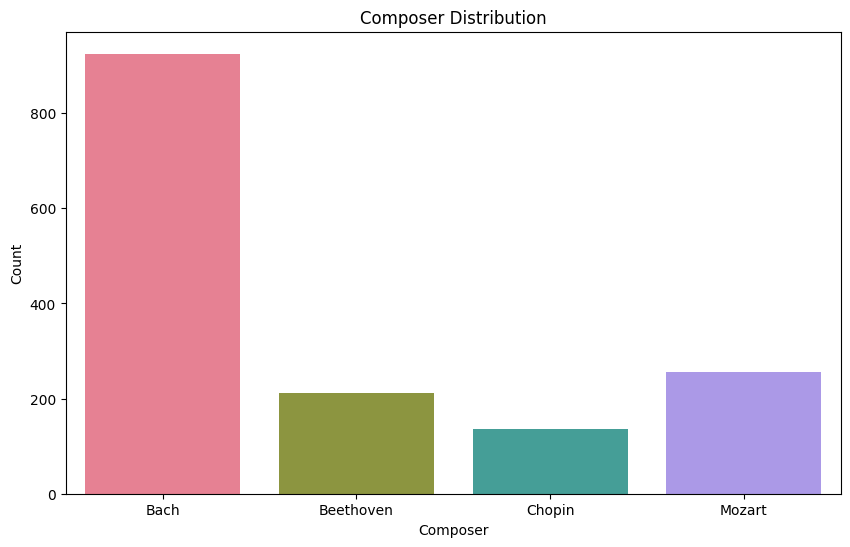

In [31]:
def plot_composer_distribution(labels, composers):
    label_counts = labels.sum(axis=0)
    
    # Select nic colors from sns 
    sns.set_palette('husl')

    # createa separate color for each composer
    colors = sns.color_palette('husl', n_colors=len(composers))

    # Plot the distribution with seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=composers, y=label_counts, palette=colors)
    plt.title('Composer Distribution')
    plt.ylabel('Count')
    plt.xlabel('Composer')
    plt.show()
    
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
plot_composer_distribution(labels, composers)

Total notes: 152800
Total labels: 152800


,Note,Composer
0,72,0
1,74,0
2,75,0
3,79,0
4,83,0


type of Composer: <class 'numpy.int64'>


,Note,Composer
0,72,Bach
1,74,Bach
2,75,Bach
3,79,Bach
4,83,Bach


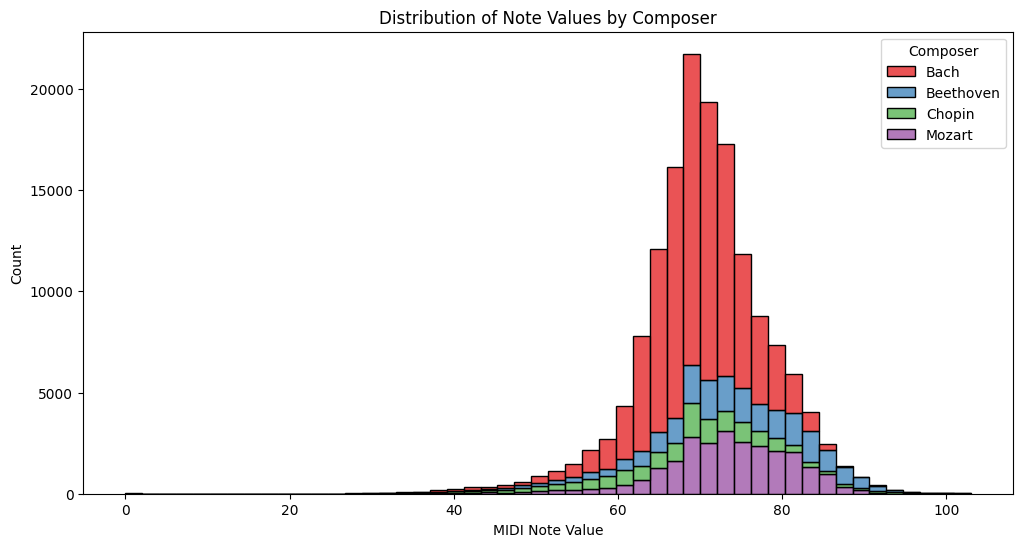

In [32]:
def plot_note_distribution(data, labels, composers):
    all_notes = []
    all_labels = []
    for notes, label in zip(data, labels):
        all_notes.extend(notes)
        all_labels.extend([label] * len(notes))

    print(f"Total notes: {len(all_notes)}")
    print(f"Total labels: {len(all_labels)}")
    
    integer_labels = [np.argmax(label) for label in all_labels]
    df = pd.DataFrame({'Note': all_notes, 'Composer': integer_labels})

    display(df.head())
    print(f"type of Composer: {type(df['Composer'][0])}") 
 
    # Ensure 'Composer' column contains only integers
    df['Composer'] = df['Composer'].astype(int)
    df['Composer'] = df['Composer'].apply(lambda x: composers[x])
    display(df.head())

    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='Note', hue='Composer', multiple='stack', bins=50, palette='Set1')
    plt.title('Distribution of Note Values by Composer')
    plt.xlabel('MIDI Note Value')
    plt.ylabel('Count')
    plt.show()


composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
plot_note_distribution(data, labels, composers)


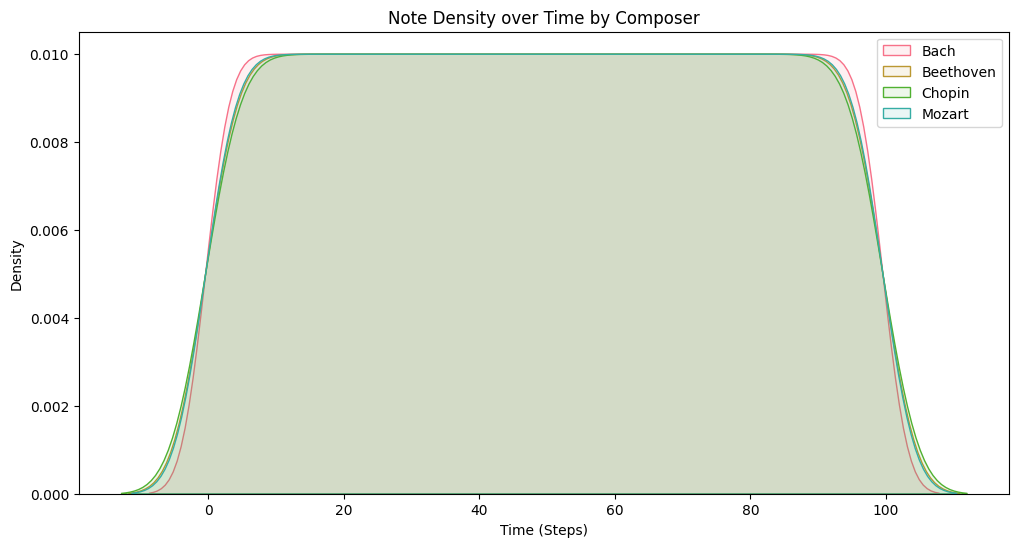

In [33]:
def plot_note_density(data, labels, composers):
    plt.figure(figsize=(12, 6))
    
    for composer_idx, composer in enumerate(composers):
        composer_data = [seq for seq, label in zip(data, labels) if label.argmax() == composer_idx]
        all_times = []
        for seq in composer_data:
            all_times.extend(range(len(seq)))
        
        sns.kdeplot(all_times, label=composer, fill=True, alpha=0.1)
    
    plt.title('Note Density over Time by Composer')
    plt.xlabel('Time (Steps)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
plot_note_density(data, labels, composers)

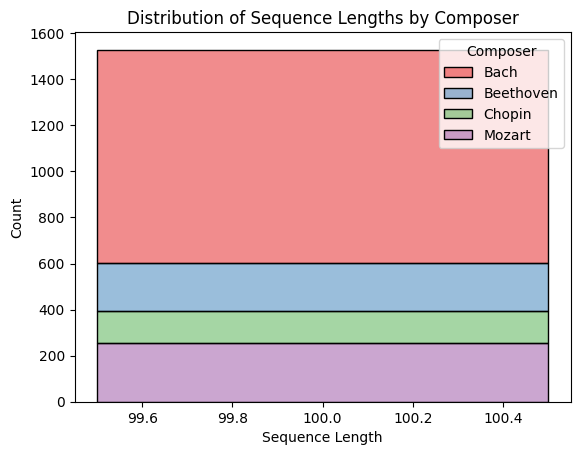

In [34]:
def plot_sequence_length_distribution(data, labels, composers):
    # Initialize a dictionary to store sequence lengths by composer
    composer_lengths = {composer: [] for composer in composers}
    
    # Calculate sequence lengths and store them in the corresponding composer's list
    for notes, label in zip(data, labels):
        composer_index = np.argmax(label)
        composer = composers[composer_index]
        composer_lengths[composer].append(len(notes))
    
    # Create a DataFrame for visualization
    df = pd.DataFrame([
        {'Composer': composer, 'Length': length}
        for composer, lengths in composer_lengths.items()
        for length in lengths
    ])
    
    # Plot the sequence length distribution
    sns.histplot(data=df, x='Length', hue='Composer', multiple='stack', palette='Set1', kde=True)
    plt.title('Distribution of Sequence Lengths by Composer')
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.show()


composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
plot_sequence_length_distribution(data, labels, composers)

In [35]:
def compile_midi_files(directory):
    # Initialize an empty list to store the paths of all MIDI files
    midi_files = []

    # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                # If it is, construct the full path to the file and add it to the list
                midi_files.append(os.path.join(root, file))

    # Return the list of all MIDI files
    return midi_files

# Specify the directory
bach_dir = 'music_data/midiclassics/Bach'
beethoven_dir = 'music_data/midiclassics/Beethoven'
chopin_dir = 'music_data/midiclassics/Chopin'
mozart_dir = 'music_data/midiclassics/Mozart'

# Compile all MIDI files from each composer
bach_midi_files = compile_midi_files(bach_dir)
beethoven_midi_files = compile_midi_files(beethoven_dir)
chopin_midi_files = compile_midi_files(chopin_dir)
mozart_midi_files = compile_midi_files(mozart_dir)

### Feature Extraction 

/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_49470/1429908962.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(midi_file.get_piano_roll(fs)[start_pitch:end_pitch],


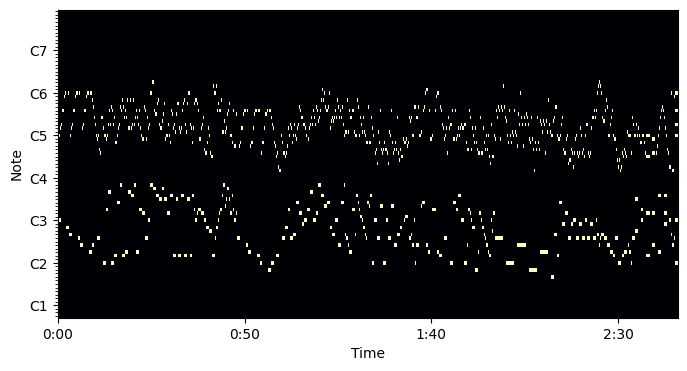

In [36]:
def plot_piano_roll(midi_file, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(midi_file.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
plt.figure(figsize=(8, 4))

# Initialize an empty list to store the PrettyMIDI objects
bach_pretty_midi_objects = []

# Iterate over each MIDI file in the bach_midi_files list
for midi_file in bach_midi_files:
    # Convert the MIDI file to a PrettyMIDI object and append it to the list
    bach_pretty_midi_objects.append(pretty_midi.PrettyMIDI(midi_file))
    
plot_piano_roll(bach_pretty_midi_objects[0], 21, 108)

In [37]:
print(bach_pretty_midi_objects[0].get_piano_roll())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


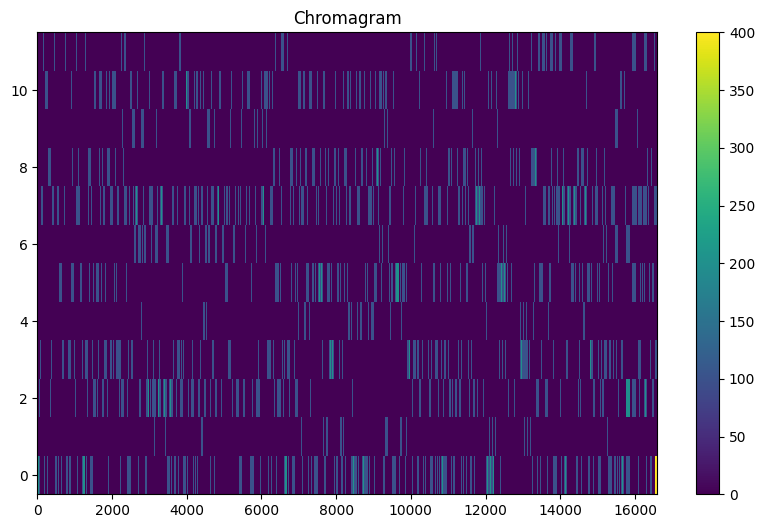

In [38]:
def plot_chromagram(midi_data):
    # Get chroma features of MIDI data
    chroma = midi_data.get_chroma()

    # Plot chromagram
    plt.figure(figsize=(10, 6))
    plt.imshow(chroma, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar()
    plt.title('Chromagram')
    plt.show()

plot_chromagram(bach_pretty_midi_objects[0])

### Model Building

In [39]:
### Test Model with a simple LSTM



### Model Training

### Model Evaluation

### Model Optimization